In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.layers import LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [29]:
tf.random.set_seed(42)
np.random.seed(42)

In [30]:
data = pd.read_csv('../data/energy_data_cleaned_wBuildingId.csv')

In [31]:
unique_buildings = data['building_id'].unique()

# Passo 2: embaralhar e dividir em treino, validação e teste
train_ids, temp_ids = train_test_split(unique_buildings, test_size=0.4, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

# Passo 3: filtrar os dados com base nesses IDs
train_df = data[data['building_id'].isin(train_ids)].copy()
val_df = data[data['building_id'].isin(val_ids)].copy()
test_df = data[data['building_id'].isin(test_ids)].copy()

# Separar X e y
X_train = train_df.drop(['target', 'timestamp', 'building_id'], axis=1)
y_train = train_df['target']

X_val = val_df.drop(['target', 'timestamp', 'building_id'], axis=1)
y_val = val_df['target']

X_test = test_df.drop(['target', 'timestamp', 'building_id'], axis=1)
y_test = test_df['target']

In [32]:

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)
# %% Scale target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


In [47]:
class R2Score(tf.keras.metrics.Metric):
    def __init__(self, name='r2_metric', **kwargs):
        super().__init__(name=name, **kwargs)
        self.sse = self.add_weight(name="sse", initializer="zeros")
        self.sst = self.add_weight(name="sst", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, self.dtype)
        y_pred = tf.cast(y_pred, self.dtype)

        residual = tf.reduce_sum(tf.square(y_true - y_pred))
        total = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))

        self.sse.assign_add(residual)
        self.sst.assign_add(total)

    def result(self):
        return 1.0 - (self.sse / (self.sst + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.sse.assign(0.0)
        self.sst.assign(0.0)


In [48]:
def build_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse', R2Score()])
    return model
input_dim = X_train_scaled.shape[1]
model = build_model(input_dim)
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,081 (55.00 KB)

 Trainable params: 13,697 (53.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [49]:
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    to_file='model0_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    dpi=96
)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [50]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=50, batch_size=64, verbose=1)


Epoch 1/50
9802/9802 ━━━━━━━━━━━━━━━━━━━━ 7s 638us/step - loss: 0.1230 - mae: 0.2431 - mse: 0.1230 - r2_metric: 0.8746 - val_loss: 0.0361 - val_mae: 0.1103 - val_mse: 0.0361 - val_r2_metric: 0.7264
Epoch 2/50
9802/9802 ━━━━━━━━━━━━━━━━━━━━ 6s 629us/step - loss: 0.0262 - mae: 0.1177 - mse: 0.0262 - r2_metric: 0.9733 - val_loss: 0.0353 - val_mae: 0.1095 - val_mse: 0.0353 - val_r2_metric: 0.7329
Epoch 3/50
9802/9802 ━━━━━━━━━━━━━━━━━━━━ 6s 637us/step - loss: 0.0211 - mae: 0.1027 - mse: 0.0211 - r2_metric: 0.9786 - val_loss: 0.0334 - val_mae: 0.1034 - val_mse: 0.0334 - val_r2_metric: 0.7471
Epoch 4/50
9802/9802 ━━━━━━━━━━━━━━━━━━━━ 6s 633us/step - loss: 0.0194 - mae: 0.0972 - mse: 0.0194 - r2_metric: 0.9802 - val_loss: 0.0331 - val_mae: 0.1023 - val_mse: 0.0331 - val_r2_metric: 0.7488
Epoch 5/50
9802/9802 ━━━━━━━━━━━━━━━━━━━━ 6s 630us/step - loss: 0.0184 - mae: 0.0940 - mse: 0.0184 - r2_metric: 0.9813 - val_loss: 0.0338 - val_mae: 0.1049 - val_mse: 0.0338 - val_r2_metric: 0.7438
Epoch 6/50

In [51]:
predictions_scaled = model.predict(X_test_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled)
y_test_orig = scaler_y.inverse_transform(y_test_scaled)

# Métricas de desempenho
mae = mean_absolute_error(y_test_orig, predictions)
mse = mean_squared_error(y_test_orig, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orig, predictions)

print(f"Test- MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")


6714/6714 ━━━━━━━━━━━━━━━━━━━━ 1s 197us/step
Test- MAE: 0.2198, MSE: 0.1233, RMSE: 0.3512, R2: 0.9604


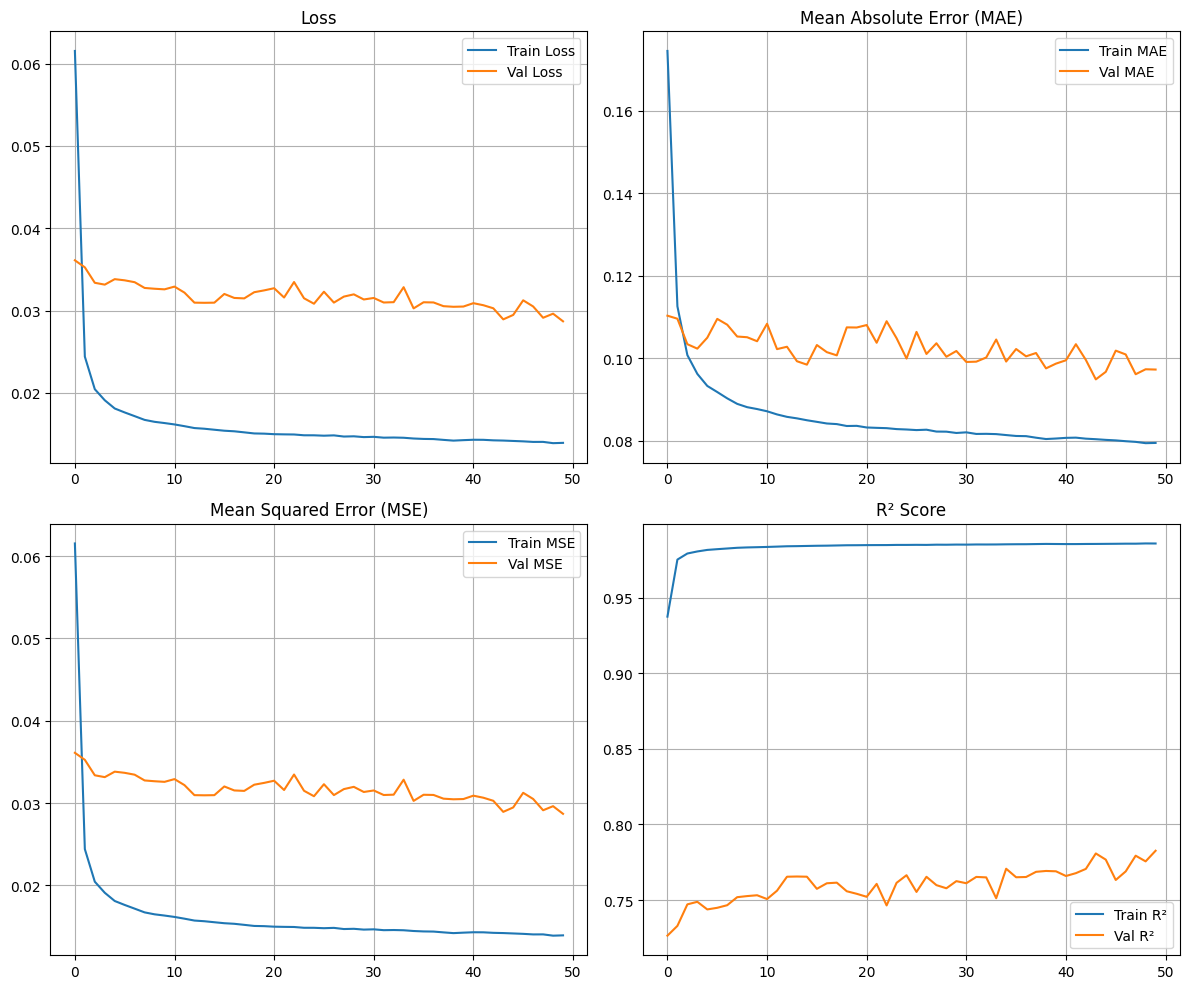

In [52]:
# Visualização do desempenho durante o treinamento
plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.grid(True)

# Plot MAE
plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title('Mean Absolute Error (MAE)')
plt.grid(True)

# Plot MSE
plt.subplot(2, 2, 3)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.legend()
plt.title('Mean Squared Error (MSE)')
plt.grid(True)

# Plot R²
plt.subplot(2, 2, 4)
plt.plot(history.history['r2_metric'], label='Train R²')
plt.plot(history.history['val_r2_metric'], label='Val R²')
plt.legend()
plt.title('R² Score')
plt.grid(True)

plt.tight_layout()
plt.show()

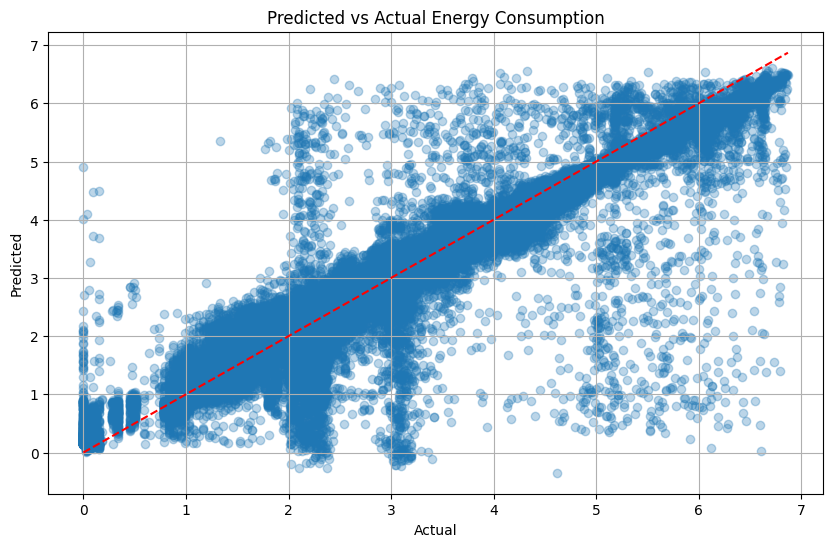

In [53]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_orig, predictions, alpha=0.3)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Energy Consumption')
plt.grid(True)
plt.show()


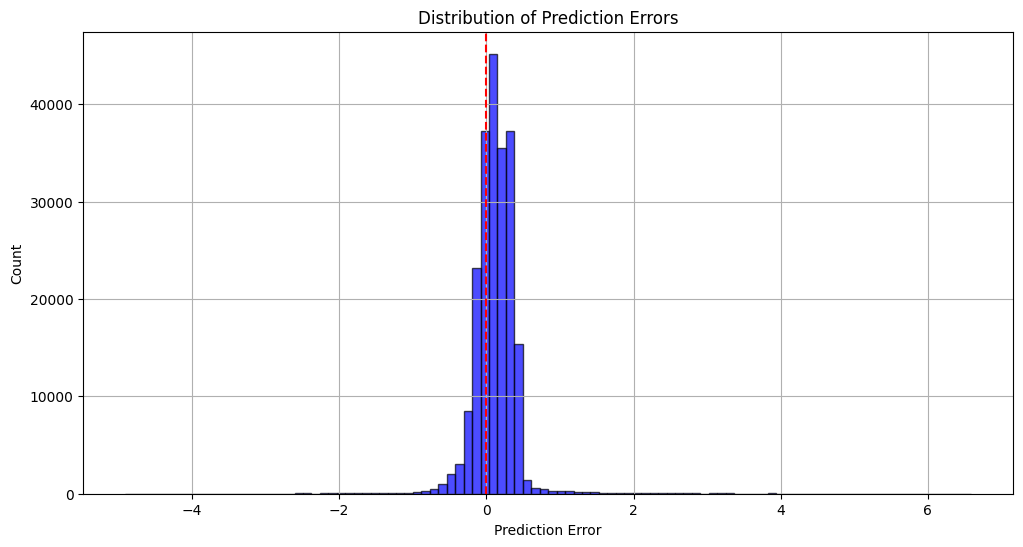

Error Analysis:
Mean Error: 0.1190
Standard Deviation of Error: 0.3304


In [54]:
error = y_test_orig - predictions
plt.figure(figsize=(12, 6))
plt.hist(error, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()

print("Error Analysis:")
print(f"Mean Error: {np.mean(error):.4f}")
print(f"Standard Deviation of Error: {np.std(error):.4f}")


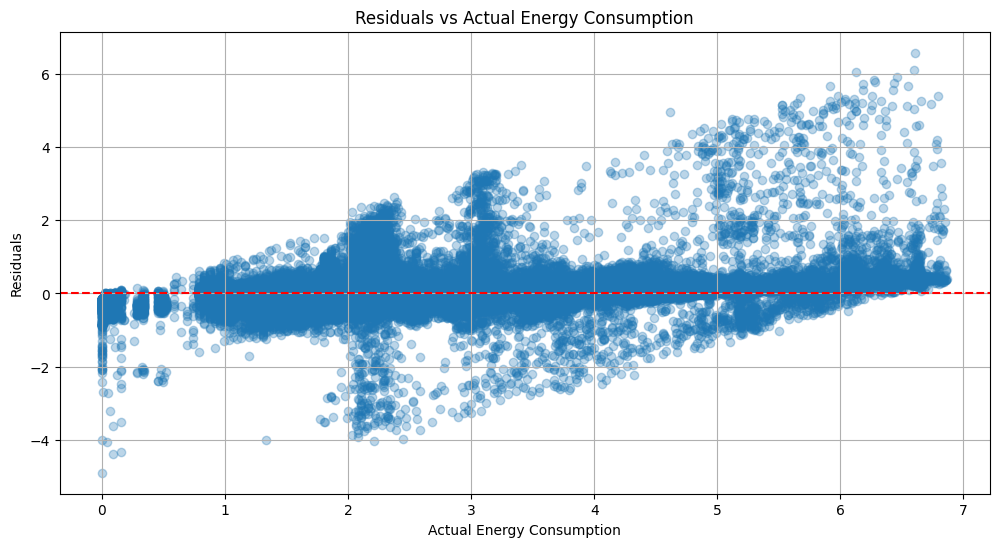

In [55]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test_orig, error, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual Energy Consumption')
plt.grid(True)
plt.show()